<center>
<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4853/media/home_depot_tools.jpg"/>
## Home Depot Product Search Relevance
</center>
<center>Автор материала: программист-исследователь Решетников Дмитрий


Shoppers rely on Home Depot’s product authority to find and buy the latest products and to get timely solutions to their home improvement needs. From installing a new ceiling fan to remodeling an entire kitchen, with the click of a mouse or tap of the screen, customers expect the correct results to their queries – quickly. Speed, accuracy and delivering a frictionless customer experience are essential.

In this competition, Home Depot is asking Kagglers to help them improve their customers' shopping experience by developing a model that can accurately predict the relevance of search results.

Search relevancy is an implicit measure Home Depot uses to gauge how quickly they can get customers to the right products. Currently, human raters evaluate the impact of potential changes to their search algorithms, which is a slow and subjective process. By removing or minimizing human input in search relevance evaluation, Home Depot hopes to increase the number of iterations their team can perform on the current search algorithms.

### Data description

This data set contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters.

The relevance is a number between 1 (not relevant) to 3 (highly relevant). For example, a search for "AA battery" would be considered highly relevant to a pack of size AA batteries (relevance = 3), mildly relevant to a cordless drill battery (relevance = 2), and not relevant to a snow shovel (relevance = 1).

Each pair was evaluated by at least three human raters. The provided relevance scores are the average value of the ratings. There are three additional things to know about the ratings:

The specific instructions given to the raters is provided in relevance_instructions.docx.
Raters did not have access to the attributes.
Raters had access to product images, while the competition does not include images.
Your task is to predict the relevance for each pair listed in the test set. Note that the test set contains both seen and unseen search terms.



### File descriptions

- train.csv - the training set, contains products, searches, and relevance scores
- test.csv - the test set, contains products and searches. You must predict the relevance for these pairs.
- product_descriptions.csv - contains a text description of each product. You may join this table to the training or test set via the product_uid.
- attributes.csv -  provides extended information about a subset of the products (typically representing detailed technical specifications). Not every product will have attributes.
- sample_submission.csv - a file showing the correct submission format
- relevance_instructions.docx - the instructions provided to human raters

### Data fields

- id - a unique Id field which represents a (search_term, product_uid) pair
- product_uid - an id for the products
- product_title - the product title
- product_description - the text description of the product (may contain HTML content)
- search_term - the search query
- relevance - the average of the relevance ratings for a given id
- name - an attribute name
- value - the attribute's value

In [2]:
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import math
import re

In [3]:
PATH_TO_DATA = '/Users/dreshetnikov/Documents/Projects/iCrossing2/Final/' 

Files spell_train.csv and spell_test.csv contains fixed search_term values  

In [4]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA,'spell_train.csv'), 
                           index_col='id', encoding = 'ISO-8859-1')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA,'spell_test.csv'), 
                           index_col='id', encoding = 'ISO-8859-1')
attributes_df = pd.read_csv(os.path.join(PATH_TO_DATA,'attributes.csv'), encoding = 'ISO-8859-1')
descriptions_df = pd.read_csv(os.path.join(PATH_TO_DATA,'product_descriptions.csv'), encoding = 'ISO-8859-1')

In [5]:
print (len(train_df), len(test_df))

74067 166693


# 1. Let's take a look at the input data

In [172]:
%matplotlib inline
from matplotlib import pyplot as plt

## 1.1 Relevance distribution

As you see from the histogram, __relevance__ column is not evenly distributed

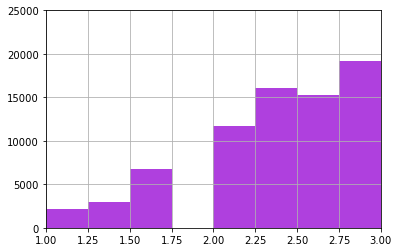

In [174]:
n, bins, patches = plt.hist(train_df['relevance'], 8, facecolor='darkviolet', alpha=0.75)
plt.axis([1, 3, 0, 25000])
plt.grid(True)
plt.show()

## 1.2. Misspelings
I've noticed, that field 'search_term' contains a lot of misspelling (more than 3000). So let's fix that using Google API. And used fixed data instead of original one.

In [48]:
import requests
import re
import time
from random import randint

START_SPELL_CHECK="<span class=\"spell\">Showing results for</span>"
END_SPELL_CHECK="<br><span class=\"spell_orig\">Search instead for"
HTML_Codes = (("'", '&#39;'),('"', '&quot;'),('>', '&gt;'),('<', '&lt;'),('&', '&amp;'))

def spell_check(s):
    q = '+'.join(s.split())
    time.sleep(  randint(0,1) ) #relax and don't let google be angry
    r = requests.get("https://www.google.co.uk/search?q="+q)
    content = r.text
    start=content.find(START_SPELL_CHECK) 
    if ( start > -1 ):
        start = start + len(START_SPELL_CHECK)
        end=content.find(END_SPELL_CHECK)
        search= content[start:end]
        search = re.sub(r'<[^>]+>', '', search)
        for code in HTML_Codes:
            search = search.replace(code[1], code[0])
        search = search[1:]
    else:
        search = s
    return search ;

## 1.3. Brand and material columns
There are several brand and material columns with different names, let's look at them

In [260]:
def filter_by_word(df, word):
    brand_bool = df.str.contains(word, flags=re.IGNORECASE, na=False)
    print ('Different %s attributes' %word, len(np.unique(df[brand_bool])))
    print ('Rows with %s attribute' %word, len(df[brand_bool]))
    print ('\n'.join(np.unique(df[brand_bool])[:5]))
    print ('...')

In [261]:
filter_by_word(attributes_df.name, 'brand')

Different brand attributes 10
Rows with brand attribute 88881
Brand compatibility
Brand/Model Compatibility
Brand/model/year compatibility
Fits Brand/Models
Fits Faucet Brand
...


In [262]:
filter_by_word(attributes_df.name, 'material')

Different material attributes 141
Rows with material attribute 63063
Accent mount material
Armor Material
Backing material
Bagging Material Included
Base Material
...


We are going to count that attribute as one feature.
Also we are going to extract color feature.

In [263]:
filter_by_word(attributes_df.name, 'color')

Different color attributes 63
Rows with color attribute 106895
Actual Color Temperature (K)
Base Color/Finish Family
Basin Color
Basin Color Family
Beam Color
...


## 1.3. Other attributes names

As far other product attributes weren't mantioned as a very important, we are not going to create additional columns, we will just add those attributes to products description as 'value name'. 

In [264]:
filter_by_word(attributes_df.name, 'Bullet')

Different Bullet attributes 23
Rows with Bullet attribute 589967
Bullet Proof
Bullet01
Bullet02
Bullet03
Bullet04
...


In [265]:
filter_by_word(attributes_df.name, 'Height')

Different Height attributes 185
Rows with Height attribute 97210
Actual Product Height (in.)
Actual Tree Height (ft.)
Actual panel height (in.)
Actual picket height (in.)
Actual post height (in.)
...


In [266]:
filter_by_word(attributes_df.name, 'Width')

Different Width attributes 247
Rows with Width attribute 111194
Actual Blind/Shade Width (In.)
Actual Product Width (in.)
Actual backer rail width (in.)
Actual panel width (in.)
Actual picket width (in.)
...


In [267]:
filter_by_word(attributes_df.name, 'Weight')

Different Weight attributes 50
Rows with Weight attribute 51517
Air handler weight (lb.)
Assembled weight (lbs)
Bag Weight (lb.)
Beam Weight (Lbs.)
Chair Weight Capacity (lb.)
...


In [268]:
filter_by_word(attributes_df.name, 'Length')

Different Length attributes 225
Rows with Length attribute 47012
Actual backer rail length (in.)
Actual picket length (ft.)
Adjustable Length
Adjustable hanging length
Adjustable screen length
...


# 2. Data transformations

### Plan
We are going to do the following:
0. Fixed misspelings in the search_term column (already done)
1. Concatenate information from all files to one DataFrame
    - extract brand/material from attributes.csv. (those parameters were mantioned as very inportant in the relevance_instructions.docx)
    - extract color from attributes.csv
    - concatinate all other attributes for each file to the description
    - remove english stop words from all text columns
    - remove all non alphabetic and non number symbols
    - stem all text columns with english dictionary
2. Create num columns based on text columns
    - count amount of similar words in the pairs search_term and all other text columns 
    - create new columns for each pair
3. Remove all text columns

As a result we will have vectors of numbers that suites well for the machine learning.

## 2.1. All input files concatenation

Let's implement several functions to prepare our data to machine learning processing 

In [52]:
def group_attrs_by_product(train_df, test_df, attributes_df, descriptions_df):
    products_attrs = dict()
    attrs_list = set()
    for product in train_df.values:
        products_attrs[product[0]] = dict()
        
        products_attrs[product[0]]['brand'] = ""
        products_attrs[product[0]]['material'] = ""
        products_attrs[product[0]]['color'] = ""
        
    for product in test_df.values:
        products_attrs[product[0]] = dict()
        
        products_attrs[product[0]]['brand'] = ""
        products_attrs[product[0]]['material'] = ""
        products_attrs[product[0]]['color'] = ""
        
        
    for attr in attributes_df.values:
        if math.isnan(attr[0]):
            continue
        
        product_uid = attr[0]
        attr_name = attr[1].lower()
        attr_value = attr[2]
        
        if ('brand' in attr_name):
            products_attrs[product_uid]['brand'] = '%s %s' %(products_attrs[product_uid]['brand'], attr_value)
        elif ('material' in attr_name):
            products_attrs[product_uid]['material'] = '%s %s' %(products_attrs[product_uid]['material'], attr_value)
        elif ('color' in attr_name):
            products_attrs[product_uid]['color'] = '%s %s' %(products_attrs[product_uid]['color'], attr_value)
        else:
            products_attrs[product_uid][attr_name] = attr_value
            attrs_list |= set([attr_name])
        
    return products_attrs, attrs_list 

In [53]:
def prepare_product_dict(df, product_attrs_dict, descriptions_df):
    products_attrs = dict()
    for product in df.values:
        products_attrs[product[0]] = dict()
        products_attrs[product[0]]['title'] =  product[1]
        
    print (len(products_attrs))
        
       
        
    for descr in descriptions_df.values:
        if descr[0] in products_attrs:
            products_attrs[descr[0]]['description'] = descr[1]
        
        
    for uid,attr_dict in product_attrs_dict.items():
        if uid in products_attrs:
            attrs_dict_copy = attr_dict.copy()
            products_attrs[uid]['brand'] = attrs_dict_copy.get('brand', '')
            attrs_dict_copy.pop('brand', None)
            products_attrs[uid]['material'] = attrs_dict_copy.get('material','')
            attrs_dict_copy.pop('material', None)
            products_attrs[uid]['color'] = attrs_dict_copy.get('color', '')
            attrs_dict_copy.pop('color', None)
            products_attrs[uid]['attrs'] = create_full_description(attrs_dict_copy)

    return products_attrs

In [54]:
stemmer = SnowballStemmer('english')
def stem(s):
    return " ".join([stemmer.stem(word) for word in s.split()])

In [55]:
def create_full_description(product_attrs):
    description_items = list()
    for name, value in product_attrs.items():
        if str(value).lower() in ['nan', '', ' ', 'no'] or str(name) in ['nan', '', ' '] or len(value) == 0:
            continue
        item = '%s %s' %(value, name)
        description_items.append(item)
        
    return " ".join(description_items).lower()

In [56]:
from nltk.corpus import stopwords

def remove_stop_words(text):
    cachedStopWords = stopwords.words("english")
    return ' '.join([word for word in text.split() if word not in cachedStopWords])

In [57]:
def prepare_str(text):
    text = re.sub(r"(\d)([a-z])", r"\1 \2", text)
    text = re.sub(r"([a-z])(\d)", r"\1 \2", text)
    text = re.sub(r"([0-9]+)( *)(inches|inch|in|')\.?", r"\1in. ", text)
    text = re.sub(r"([0-9]+)( *)(foot|feet|ft|'')\.?", r"\1ft. ", text)
    text = re.sub(r"([0-9]+)( *)(pounds|pound|lbs|lb)\.?", r"\1lb. ", text)
    text = re.sub(r"([0-9]+)( *)(square|sq) ?\.?(feet|foot|ft)\.?", r"\1sq.ft. ", text)
    text = re.sub(r"([0-9]+)( *)(cubic|cu) ?\.?(feet|foot|ft)\.?", r"\1cu.ft. ", text)
    text = re.sub(r"([0-9]+)( *)(gallons|gallon|gal)\.?", r"\1gal. ", text)
    text = re.sub(r"([0-9]+)( *)(ounces|ounce|oz)\.?", r"\1oz. ", text)
    text = re.sub(r"([0-9]+)( *)(centimeters|cm)\.?", r"\1cm. ", text)
    text = re.sub(r"([0-9]+)( *)(milimeters|mm)\.?", r"\1mm. ", text)
    text = text.replace("°"," degrees ")
    text = re.sub(r"([0-9]+)( *)(degrees|degree)\.?", r"\1deg. ", text)
    text = text.replace(" v "," volts ")
    text = re.sub(r"([0-9]+)( *)(volts|volt)\.?", r"\1volt. ", text)
    text = re.sub(r"([0-9]+)( *)(watts|watt)\.?", r"\1watt. ", text)
    text = re.sub(r"([0-9]+)( *)(amperes|ampere|amps|amp)\.?", r"\1amp. ", text)
    text = remove_stop_words(text)
    text = re.sub(r'\W+', ' ', text.lower())
    text = stem(text)
    return text

In [58]:
def create_dataframe(df, dictionary, column_names):
    rows = list()
    for r in df.values:
        uid = r[0]
        attrs = dictionary[uid]
        row = list()
        row.append(uid)
        row.append(prepare_str(attrs.get('title', '')))
        row.append(prepare_str('%s %s' % (attrs.get('description', ''), attrs.get('attrs', ''))))
        row.append(prepare_str(attrs.get('brand', '')))
        row.append(prepare_str(attrs.get('material', '')))
        row.append(prepare_str(attrs.get('color', '')))
        row.append(prepare_str(r[1])) # search_term
        row.append(len(prepare_str(r[1]).split())) # length of search_term
        if (len(r) == 3):
            row.append(r[2]) # relevance
        rows.append(row)
        
    return pd.DataFrame.from_records(rows, columns = column_names) 

In [59]:
%%time
attrs, attrs_list = group_attrs_by_product(train_df, test_df, attributes_df, descriptions_df)

CPU times: user 6.23 s, sys: 241 ms, total: 6.47 s
Wall time: 6.54 s


In [60]:
%%time
train_products_dict = prepare_product_dict(train_df, attrs, descriptions_df)

54667
CPU times: user 1.82 s, sys: 51.9 ms, total: 1.87 s
Wall time: 1.88 s


In [61]:
%%time
test_products_dict = prepare_product_dict(test_df, attrs, descriptions_df)

97460
CPU times: user 3.39 s, sys: 102 ms, total: 3.5 s
Wall time: 3.52 s


In [62]:
column_names = ['product_uid', 'product_title', 'product_description', 'brand', 'material', 'color', 'search_term', 'search_length', 'relevance']
test_column_names = ['product_uid', 'product_title', 'product_description', 'brand', 'material', 'color', 'search_term', 'search_length']

In [63]:
%%time
full_train_df = create_dataframe(train_df[['product_uid', 'search_term', 'relevance']], train_products_dict, column_names)

CPU times: user 10min 53s, sys: 19 s, total: 11min 12s
Wall time: 11min 17s


In [64]:
%%time
full_test_df = create_dataframe(test_df[['product_uid', 'search_term']], test_products_dict, test_column_names)

CPU times: user 25min 36s, sys: 44.5 s, total: 26min 21s
Wall time: 26min 48s


#### Save transformed data to csv file

In [65]:
full_train_df.to_csv("full_train_df.csv", index_label = 'id')
full_test_df.to_csv("full_test_df.csv", index_label = 'id')

#### Restore saved state of data from csv files

In [96]:
full_train_df = pd.read_csv(os.path.join(PATH_TO_DATA,'full_train_df.csv'), index_col='id')
full_test_df = pd.read_csv(os.path.join(PATH_TO_DATA,'full_test_df.csv'), index_col='id')

In [97]:
full_train_df.head()

,product_uid,product_title,product_description,brand,material,color,search_term,search_length,relevance
id,,,,,,,,,
0,100001,simpson strong tie 12 gaug angl,not angl make joint stronger also provid consi...,simpson strong tie,galvan steel,NaN,angl bracket,2,3.00
1,100001,simpson strong tie 12 gaug angl,not angl make joint stronger also provid consi...,simpson strong tie,galvan steel,NaN,l bracket,2,2.50
2,100002,behr premium textur deckov 1 gal sc 141 tugboa...,behr premium textur deckov innov solid color c...,behr premium textur deckov,NaN,brown tan tugboat,deck,1,3.00
3,100005,delta vero 1 handl shower onli faucet trim kit...,updat bathroom delta vero singl handl shower f...,delta,NaN,chrome chrome,rain shower head,3,2.33
4,100005,delta vero 1 handl shower onli faucet trim kit...,updat bathroom delta vero singl handl shower f...,delta,NaN,chrome chrome,shower faucet,2,2.67


## 2.2. Transformation of text columns to num columns
Let's count amount of similar words in search_term and other text columns

In [98]:
def count_strs_similarity(str_to_find, big_str):
    sum = 0
    if (str(str_to_find) == 'nan' ):
        return 0
    
    big_str = str(big_str)
    for text in str_to_find.split():
        
        if text in big_str:
            sum = sum + 1
    return sum

In [100]:
def count_strs_similarity_v2(str_to_find, big_str):
    sum = 0
    if (str(str_to_find) == 'nan' ):
        return 0
    
    big_str = str(big_str)
    for text in str_to_find.split():
        
        if text in big_str:
            sum = sum + 1
    return sum/len(big_str)

In [99]:
main_columns_list = ['product_title', 'product_description', 'brand', 'material', 'color']
def new_similarity_column(source_column_name, df):
    df['%s_similarity'%source_column_name] = [*map(count_strs_similarity, df['search_term'], df[source_column_name])]
    df['%s_similarity_v2'%source_column_name] = [*map(count_strs_similarity_v2, df['search_term'], df[source_column_name])]
    
def count_query_similarities(df):
    [*map(lambda x: new_similarity_column(x, df), main_columns_list)]
    

In [92]:
count_query_similarities(full_train_df)
count_query_similarities(full_test_df)

#### Save transformed data to csv file

In [93]:
full_train_df.to_csv("similar_count_train_df.csv", index_label = 'id')
full_test_df.to_csv("similar_count_test_df.csv", index_label = 'id')

#### Restore saved state of data from csv files

In [94]:
full_train_df = pd.read_csv(os.path.join(PATH_TO_DATA,'similar_count_train_df.csv'), index_col='id')
full_test_df = pd.read_csv(os.path.join(PATH_TO_DATA,'similar_count_test_df.csv'), index_col='id')

In [95]:
full_train_df.head(5)

,product_uid,product_title,product_description,brand,material,color,search_term,search_length,relevance,product_title_similarity,product_description_similarity,brand_similarity,material_similarity,color_similarity
id,,,,,,,,,,,,,,
0,100001,simpson strong tie 12 gaug angl,not angl make joint stronger also provid consi...,simpson strong tie,galvan steel,NaN,angl bracket,2,3.00,1,1,0,0,0
1,100001,simpson strong tie 12 gaug angl,not angl make joint stronger also provid consi...,simpson strong tie,galvan steel,NaN,l bracket,2,2.50,1,1,0,1,0
2,100002,behr premium textur deckov 1 gal sc 141 tugboa...,behr premium textur deckov innov solid color c...,behr premium textur deckov,NaN,brown tan tugboat,deck,1,3.00,1,1,1,0,0
3,100005,delta vero 1 handl shower onli faucet trim kit...,updat bathroom delta vero singl handl shower f...,delta,NaN,chrome chrome,rain shower head,3,2.33,1,3,0,0,0
4,100005,delta vero 1 handl shower onli faucet trim kit...,updat bathroom delta vero singl handl shower f...,delta,NaN,chrome chrome,shower faucet,2,2.67,2,2,0,0,0


## 2.3. Removal of all text columns 
We are going to remove all text columns, so only columns with numbers will survive.

In [77]:
def add_word_count(df):
    df['title_len'] = [*map(lambda x: len(str(x).split()), df['product_title'])]
    df['description_len'] = [*map(lambda x: len(str(x).split()), df['product_description'])]
    df['brand_len'] = [*map(lambda x: len(str(x).split()), df['brand'])]
    
def drop_text_columns(df):
    df.drop(main_columns_list, axis=1, inplace=True)
    df.drop('search_term', axis=1, inplace=True)
    df.drop('product_uid', axis=1, inplace=True)

In [78]:
add_word_count(full_train_df)
add_word_count(full_test_df)

drop_text_columns(full_train_df)
drop_text_columns(full_test_df)

In [79]:
full_train_df.head(5)

,search_length,relevance,product_title_similarity,product_title_similarity_v2,product_description_similarity,product_description_similarity_v2,brand_similarity,brand_similarity_v2,material_similarity,material_similarity_v2,color_similarity,color_similarity_v2,title_len,description_len,brand_len
id,,,,,,,,,,,,,,,
0,2,3.00,1,0.032258,1,0.000965,0,0.000000,0,0.000000,0,0.0,6,183,3
1,2,2.50,1,0.032258,1,0.000965,0,0.000000,1,0.083333,0,0.0,6,183,3
2,1,3.00,1,0.015385,1,0.000560,1,0.038462,0,0.000000,0,0.0,12,309,4
3,3,2.33,1,0.014493,3,0.002406,0,0.000000,0,0.000000,0,0.0,13,207,1
4,2,2.67,2,0.028986,2,0.001604,0,0.000000,0,0.000000,0,0.0,13,207,1


#### Save transformed data to csv file

In [80]:
full_train_df.to_csv("only_similarity_train_df.csv", index_label = 'id')
full_test_df.to_csv("only_similarity_test_df.csv", index_label = 'id')

#### Restore saved state of data from csv files

In [81]:
full_train_df = pd.read_csv(os.path.join(PATH_TO_DATA,'only_similarity_train_df.csv'), index_col='id')
full_test_df = pd.read_csv(os.path.join(PATH_TO_DATA,'only_similarity_test_df.csv'), index_col='id')

## 2.4 Let's look at new train and  test features statistics

In [82]:
full_train_df.describe()

,search_length,relevance,product_title_similarity,product_description_similarity,brand_similarity,material_similarity,color_similarity,title_len,description_len,brand_len
count,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000,74067.000000
mean,3.172722,2.381634,2.135620,2.262695,0.211106,0.059055,0.093105,11.277600,203.430462,1.511321
std,1.322487,0.533984,1.230287,1.265563,0.504043,0.255834,0.346722,3.932441,130.911549,1.084582
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000,1.000000
25%,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,8.000000,117.000000,1.000000
50%,3.000000,2.330000,2.000000,2.000000,0.000000,0.000000,0.000000,11.000000,173.000000,1.000000
75%,4.000000,3.000000,3.000000,3.000000,0.000000,0.000000,0.000000,14.000000,256.000000,2.000000
max,14.000000,3.000000,13.000000,13.000000,5.000000,3.000000,4.000000,32.000000,1830.000000,51.000000


In [83]:
full_test_df.describe()

,search_length,product_title_similarity,product_description_similarity,brand_similarity,material_similarity,color_similarity,title_len,description_len,brand_len
count,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000,166693.000000
mean,2.998578,2.062336,2.207663,0.217994,0.061370,0.091474,11.189024,211.509637,1.548907
std,1.323754,1.223047,1.253779,0.506435,0.256186,0.344623,3.942649,129.872492,1.064206
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,9.000000,1.000000
25%,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,8.000000,126.000000,1.000000
50%,3.000000,2.000000,2.000000,0.000000,0.000000,0.000000,11.000000,179.000000,1.000000
75%,4.000000,3.000000,3.000000,0.000000,0.000000,0.000000,14.000000,264.000000,2.000000
max,14.000000,14.000000,14.000000,5.000000,4.000000,6.000000,31.000000,1830.000000,48.000000


## 2.5 Visualization

In [84]:
from matplotlib import pyplot as plt
from operator import itemgetter
from collections import defaultdict

#### Features histograms

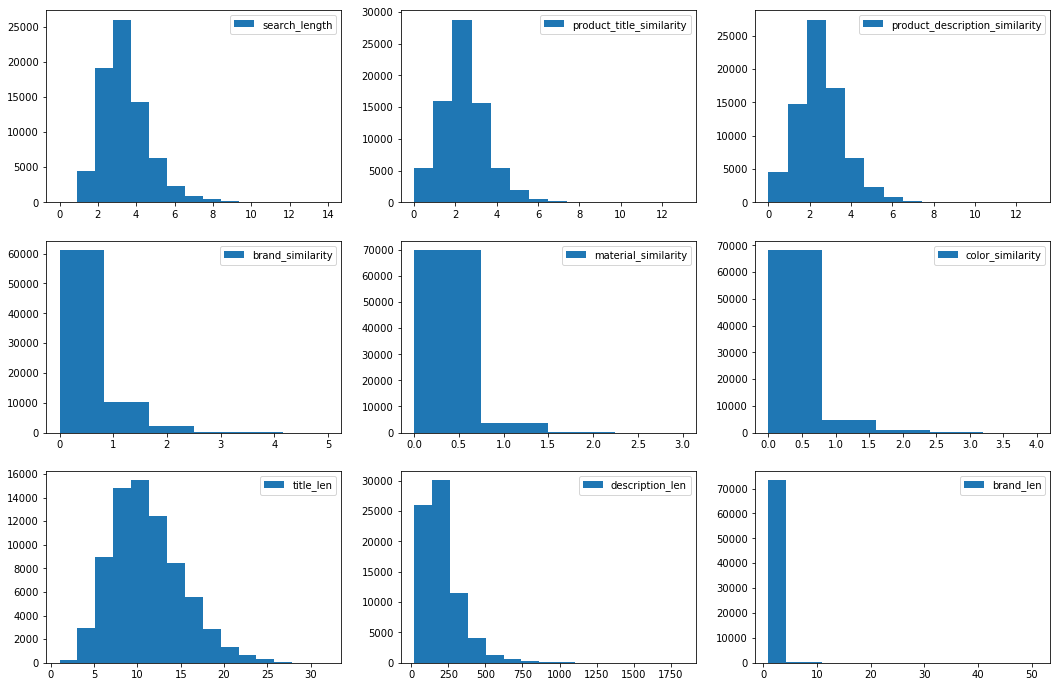

In [85]:
fig, axes = plt.subplots(nrows=int(len(full_test_df.columns)/3), ncols=3, figsize=(18, 12))

for idx, colname in  enumerate(full_test_df.columns): 
    ax = axes[int(idx/3)][idx%3]
    uniq = np.unique(full_train_df[colname])
    val_max = np.max(full_train_df[colname].values)
    ax.hist(full_train_df[colname], bins = (15 if len(uniq) > 15 else len(uniq)))
    ax.set_label(colname)
    ax.legend([colname])
    
plt.show()

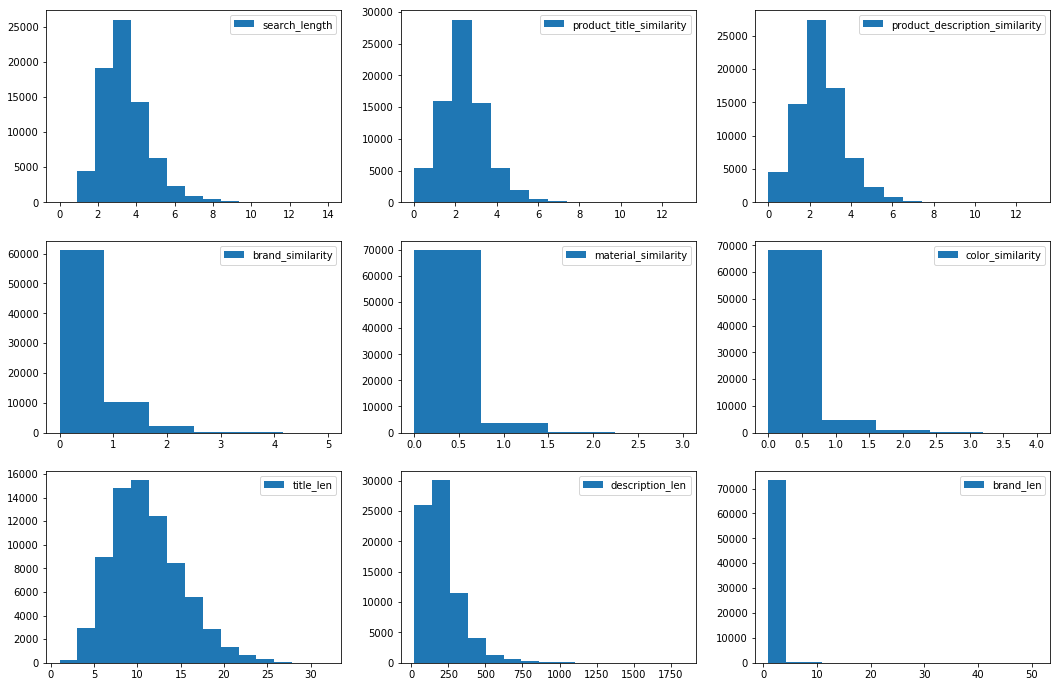

In [112]:
fig, axes = plt.subplots(nrows=int(len(full_test_df.columns)/3), ncols=3, figsize=(18, 12))

for idx, colname in  enumerate(full_test_df.columns): 
    ax = axes[int(idx/3)][idx%3]
    uniq = np.unique(full_train_df[colname])
    val_max = np.max(full_train_df[colname].values)
    ax.hist(full_train_df[colname], bins = (15 if len(uniq) > 15 else len(uniq)))
    ax.set_label(colname)
    ax.legend([colname])
    
plt.show()

#### Features and target box plots

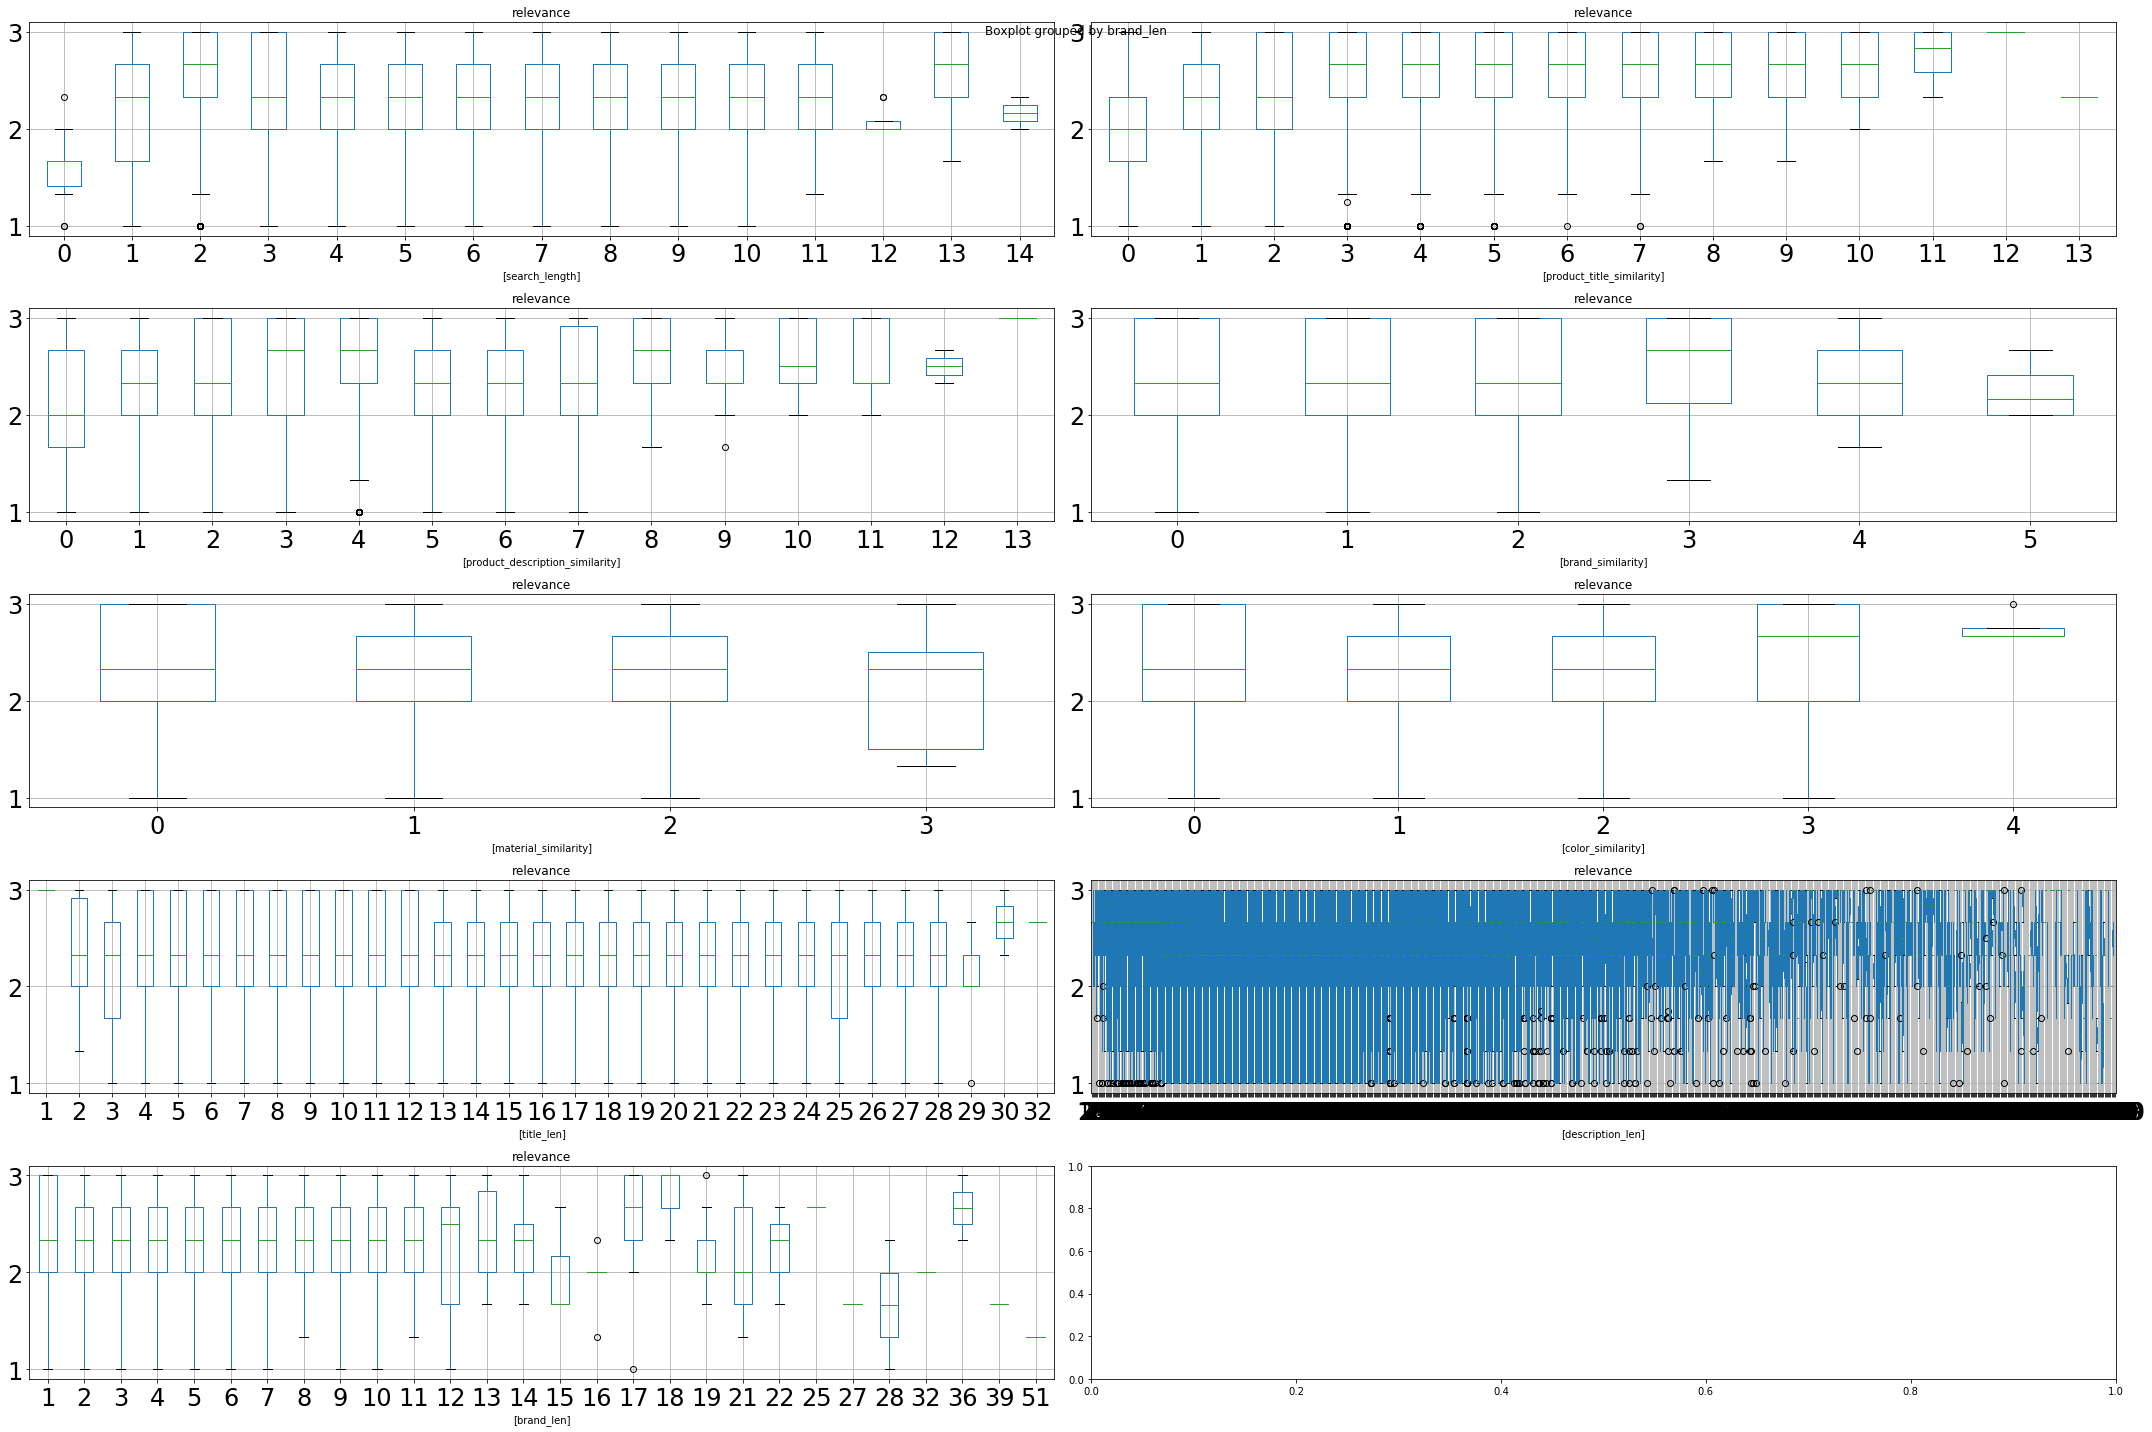

In [143]:
plt.close('all')
col_amount = 2
fig, axes = plt.subplots(nrows=int(len(full_test_df.columns)/col_amount) + 1, ncols=col_amount, figsize=(30, 20))
for idx, colname in  enumerate(full_test_df.columns): 
    ax = axes[int(idx/col_amount)][idx%col_amount]
    ax.set_title(colname, fontsize=50)
    full_train_df[[colname, 'relevance']].boxplot(by=colname, ax = ax, fontsize = 24)
plt.tight_layout()
plt.show()

# 3. Let's machine learning begin!
first of all let's create training and test data sets

Our result ~0.48 is better than RMSE of constant algorithm ~0.53.

In [5]:
X_train = full_train_df.drop(['relevance'], axis=1)
X_test = full_test_df
y_train = full_train_df['relevance']

We are going to test following regressors:
1. RandomForestRegressor
2. LinearRegression
4. GradientBoostingRegressor 
5. BaggingRegressor
6. XGBoost
7. CatBoost
8. Naive Baies
8. PolynomialFeatures for all previous algorithms

In [101]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
# suprress warnings
import warnings
warnings.filterwarnings('ignore')

We are going to use StratifiedKFold as a cross-validator with 10 folds

In [7]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=17)

Kagge uses root MSE as scoring function. So let's implement this based on the standard MSE scoring function. 

In [8]:
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

RMSE  = make_scorer(fmean_squared_error, greater_is_better=False)

## 3.0. Compare with constant algorithm
Let's find out the RMSE of the constant algorithm. Let the constatnt be equal to the mean value of the y_train 

In [147]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error([np.mean(y_train)]*len(y_train), y_train)
mse**0.5

0.53398034366913216

## 3.1 RandomForestRegressor
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [102]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
rfr = RandomForestRegressor(n_estimators = 500, n_jobs = -1, random_state = 17, verbose = 1)

In [ ]:
%%time
param_grid = {
                'n_estimators': [500], #[100, 300, 500], 
                'max_depth': [20],#, 50, 100],
                'max_features': ['sqrt']#['auto', 'sqrt', 'log2'],
             }
model_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_rfr.fit(X_train, y_train)

In [43]:
print (model_rfr.best_score_)
print (model_rfr.best_params_)
# Kaggle result - 0.49509

-0.485378348723
{'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 500}


## 3.2 LinearRegression
Ordinary least squares Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
%%time
lr = LinearRegression(n_jobs = -1)
param_grid = {}
model_lr = GridSearchCV(estimator = lr, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_lr.fit(X_train, y_train)

CPU times: user 427 ms, sys: 114 ms, total: 541 ms
Wall time: 1.59 s


In [15]:
print (model_lr.best_score_)
print (model_lr.best_params_)
# Kaggle result - 

-0.489821667644
{}


## 3.4 GradientBoostingRegressor
Gradient Boosting for regression. It produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. 

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

In [270]:
gbr = GradientBoostingRegressor()

In [286]:
%%time
param_grid = {
                'loss' : ['ls'],
                'n_estimators' : [100], 
                'max_depth' : [7],
                'max_features' : ['auto'] 
             }
model_gbr = GridSearchCV(estimator = gbr, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_gbr.fit(X_train, y_train)

CPU times: user 20.1 s, sys: 648 ms, total: 20.7 s
Wall time: 2min 35s


In [287]:
print (model_gbr.best_score_)
print (model_gbr.best_params_)
# Kaggle result - 0.48064


#-0.477212232462
#{'loss': 'ls', 'n_estimators': 100}

#-0.476795818082
#{'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 100}

#-0.477708306352
#{'loss': 'ls', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200}

-0.476753417604
{'loss': 'ls', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 100}


## 3.5 BaggingRegressor based on  RandomForestRegressor
A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.

In [52]:
from sklearn.ensemble import BaggingRegressor

In [53]:
rf = RandomForestRegressor(max_depth = 20, max_features =  'sqrt', n_estimators = 500)
clf = BaggingRegressor(rf, n_estimators=10, max_samples=0.1, random_state=25)


In [144]:
%%time
param_grid = {'bootstrap': [True, False], 'bootstrap_features': [True, False]}
model_bagging = GridSearchCV(estimator = clf, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_bagging.fit(X_train, y_train)

CPU times: user 1min, sys: 3.17 s, total: 1min 3s
Wall time: 31min 44s


In [145]:
print (model_bagging.best_score_)
print (model_bagging.best_params_)
# Training -0.478894206917 Kaggle result - 0.48470

-0.47819817516
{'bootstrap': True, 'bootstrap_features': False}


## 3.6 Naive Bayes

In [23]:
from sklearn.linear_model import BayesianRidge

In [158]:
gnb = BayesianRidge()
param_grid = {}
model_nb = GridSearchCV(estimator = gnb, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_nb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=17, shuffle=True),
       error_score='raise',
       estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(fmean_squared_error, greater_is_better=False),
       verbose=0)

In [159]:
print (model_nb.best_score_)
print (model_nb.best_params_)

-0.489821605943
{}


## 3.7 XGBoost

In [70]:
from xgboost import XGBRegressor

In [71]:
%%time
xgb = XGBRegressor()
param_grid = {'max_depth':[5, 6], 
              'n_estimators': [130, 150, 170], 
              'learning_rate' : [0.1]}
model_xgb = GridSearchCV(estimator = xgb, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_xgb.fit(X_train, y_train)

CPU times: user 7.67 s, sys: 558 ms, total: 8.23 s
Wall time: 3min 51s


In [72]:
print (model_xgb.best_score_)
print (model_xgb.best_params_)

-0.475695628143
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}


## 3.8 CatBoost

In [233]:
from catboost import CatBoostRegressor

In [232]:
from sortedcontainers import SortedList
import copy
import collections
import numpy as np
from itertools import product,chain
import pandas
from sklearn.model_selection import KFold
import catboost as cb

class paramsearch:
    def __init__(self,pdict):    
        self.pdict = {}
        for a,b in pdict.items():
            if isinstance(b, collections.Sequence) and not isinstance(b, str): self.pdict[a] = b
            else: self.pdict[a] = [b]
        self.results = SortedList()       
                    
    def grid_search(self,keys=None):
        if keys==None: keylist = self.pdict.keys()
        else: keylist = keys
 
        listoflists = [] # this will be list of lists of key,value pairs
        for key in keylist: listoflists.append([(key,i) for i in self.pdict[key]])
        for p in product(*listoflists):
            if len(self.results)>0: template = self.results[-1][1]
            else: template = {a:b[0] for a,b in self.pdict.items()}
            if self.equaldict(dict(p),template): continue
            yield self.overwritedict(dict(p),template)
                              
    def equaldict(self,a,b):
        for key in a.keys(): 
            if a[key] != b[key]: return False
        return True            
                              
    def overwritedict(self,new,old):
        old = copy.deepcopy(old)
        for key in new.keys(): old[key] = new[key]
        return old            

    def register_result(self,result,params):
        self.results.add((result+np.random.randn()*1e-10,params))    
        
    def bestscore(self):
        return self.results[0][0]
        
    def bestparam(self):
        return self.results[0][1]

In [245]:
from sklearn.metrics import mean_squared_error
def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]

        labels = train_label.ix[train_index]
        test_labels = train_label.ix[test_index]

        clf = CatBoostRegressor(**params)
        clf.fit(train, np.ravel(labels), cat_features=cat_dims)
        
        res.append(math.sqrt(mean_squared_error(clf.predict(test), np.ravel(test_labels))))
    return np.mean(res)

In [267]:
def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['ctr_border_count']),
                      ps.grid_search(['l2_leaf_reg']), 
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['feature_border_type']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
        ps.register_result(res,prms)
    return ps.bestparam()

In [253]:
params = {'depth':[3,1,2,6,4],
          'iterations':[1000, 2000, 3000],
          'learning_rate':[0.25, 0.22,0.27], 
          'l2_leaf_reg':[100, 150, 200, 250],
          'border_count':[None, 25, 50,75, 100, 150],
          'ctr_border_count':[None, 50,5,10,20,100,200],
          'feature_border_type': ['Median', 'Uniform', 'UniformAndQuantiles', 'MaxSumLog', 'MinEntropy', 'GreedyLogSum'],
          'thread_count':4}

In [ ]:
%%time
bestparams = catboost_param_tune(params,X_train,y_train)

In [255]:
bestparams

{'border_count': 100,
 'ctr_border_count': None,
 'depth': 3,
 'feature_border_type': 'Median',
 'iterations': 1000,
 'l2_leaf_reg': 100,
 'learning_rate': 0.25,
 'thread_count': 4}

In [256]:
%%time
# train classifier with tuned parameters    
model_catboost = cb.CatBoostRegressor(**bestparams)
model_catboost.fit(X_train, np.ravel(y_train))

CPU times: user 54.2 s, sys: 7.14 s, total: 1min 1s
Wall time: 22.6 s


In [258]:
math.sqrt(model_catboost.score(X_train, np.ravel(y_train)))

0.47287644275271395

## 3.9 Polynomial Features with other regressors
Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.

### 3.9.1 LinearRegression

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [17]:
%%time
poly_pipe = Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('linear', LinearRegression())])
lr = LinearRegression(n_jobs = -1)
param_grid = {'poly__degree': [2, 3, 4]}
model_lr_poly = GridSearchCV(estimator = poly_pipe, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_lr_poly.fit(X_train, y_train)

CPU times: user 3.09 s, sys: 497 ms, total: 3.59 s
Wall time: 1min 54s


In [18]:
print (model_lr_poly.best_score_)
print (model_lr_poly.best_params_)
# Kaggle result - 0.49175

-0.481970840645
{'poly__degree': 3}


### 3.9.2 BaggingRegressor

In [149]:
%%time
rf = RandomForestRegressor(max_depth = 20, max_features =  'sqrt', n_estimators = 500)
clf = BaggingRegressor(rf, n_estimators=10, max_samples=0.1, random_state=25)


poly_pipe = Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('bagging', clf)])
param_grid = {'poly__degree': [2, 3, 4]}
model_bagging_poly = GridSearchCV(estimator = poly_pipe, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_bagging_poly.fit(X_train, y_train)

CPU times: user 1min 52s, sys: 5.27 s, total: 1min 57s
Wall time: 1h 27min 34s


In [162]:
print (model_bagging_poly.best_score_)
print (model_bagging_poly.best_params_)
# 0.48370

-0.478269059855
{'poly__degree': 2}


### 3.9.3 GradientBoostingRegressor

In [46]:
%%time
gbr = GradientBoostingRegressor(learning_rate = 0.1, loss = 'ls', n_estimators = 100)

poly_pipe = Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('bagging', gbr)])
param_grid = {'poly__degree': [2, 3, 4]}
model_gbr_poly = GridSearchCV(estimator = poly_pipe, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_gbr_poly.fit(X_train, y_train)

CPU times: user 2min 24s, sys: 2.98 s, total: 2min 27s
Wall time: 1h 24min 35s


In [163]:
print (model_gbr_poly.best_score_)
print (model_gbr_poly.best_params_)
# 0.48087

-0.477001813071
{'poly__degree': 3}


### 3.9.4 XGBoost

In [48]:
%%time
xgb = XGBRegressor()
param_grid = {'max_depth':[3, 5], 
              'n_estimators': [50, 100, 200], 
              'learning_rate' : [0.01, 0.1]}
poly_pipe = Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('bagging', xgb)])
param_grid = {'poly__degree': [2, 3, 4]}
model_xgb_poly = GridSearchCV(estimator = poly_pipe, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_xgb_poly.fit(X_train, y_train)

CPU times: user 50.9 s, sys: 954 ms, total: 51.9 s
Wall time: 21min 14s


In [49]:
print (model_xgb_poly.best_score_)
print (model_xgb_poly.best_params_)
# Kaggle 0.48044

-0.476999956289
{'poly__degree': 3}


### 3.9.5 Bayes

In [50]:
nb = BayesianRidge()
poly_pipe = Pipeline([('poly', PolynomialFeatures(degree=3)),
                   ('bagging', nb)])
param_grid = {'poly__degree': [2, 3, 4]}
model_nb_poly = GridSearchCV(estimator = poly_pipe, param_grid = param_grid, n_jobs = -1, cv = skf, scoring=RMSE)
model_nb_poly.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('bagging', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'poly__degree': [2, 3, 4]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring=make_scorer(fmean_squared_error, greater_is_better=False),
       verbose=0)

In [51]:
print (model_nb_poly.best_score_)
print (model_nb_poly.best_params_)
# 0.49145

-0.482520070387
{'poly__degree': 3}


# 4. Prepare modes predictions to submit

In [57]:
def remove_outliers(x):
    if x < 1: return 1
    elif x > 3: return 3
    else: return x

Let's submit all received predictions to the kaggle.

In [58]:
original_test_df = pd.read_csv(os.path.join(PATH_TO_DATA,'spell_test.csv'), encoding = 'ISO-8859-1')
ids = original_test_df['id']

In [59]:
def write_predictions(prediction, file_suffix):
    pd.DataFrame({"id": ids, "relevance": prediction}).to_csv('submission_%s.csv'%file_suffix,index=False)

def write_submission(estimator, file_suffix):
    prediction = np.array([*map(remove_outliers, estimator.predict(X_test))])
    write_predictions(prediction, file_suffix)


In [ ]:
write_submission(model_rfr.best_estimator_, 'forest')

In [31]:
write_submission(model_lr.best_estimator_, 'linear_regression')

In [288]:
write_submission(model_gbr.best_estimator_, 'linear_gradient_boost')

In [161]:
write_submission(model_bagging.best_estimator_, 'forest_bagging')

In [160]:
write_submission(model_nb.best_estimator_, 'naive_baies')

In [152]:
write_submission(model_xgb.best_estimator_, 'xgboost')

In [276]:
write_submission(model_catboost, 'catboost')

In [154]:
write_submission(model_lr_poly.best_estimator_, 'linear_regression_poly')

In [155]:
write_submission(model_bagging_poly.best_estimator_, 'bagging_poly')

In [156]:
write_submission(model_gbr_poly.best_estimator_, 'gradient_boosing_poly')

In [66]:
write_submission(model_xgb_poly.best_estimator_, 'xgb_poly')

In [275]:
write_submission(model_nb_poly.best_estimator_, 'naive_baies_poly')

# Results

## Regressors result comparisson


|Regressor|Train|Kaggle
|:----------------------|----------|----------|
|CatBoostRegressor|0.47255|0.48021|
|XGBRegressor|0.47570|0.48044|
|GradientBoostingRegressor|0.47680|0.48064|
|PolynomialFeatures on GradientBoostingRegressor|0.47700|0.48087|
|PolynomialFeatures on XGBRegressor|0.47700|0.48091|
|PolynomialFeatures on LinearRegression|0.48197|0.48297|
|PolynomialFeatures on BaggingRegressor on RandomForestRegressor|0.47827|0.48370|
|BaggingRegressor on RandomForestRegressor|0.47820|0.48470|
|BayesianRidge|0.48982|0.49145|
|LinearRegression|0.48982|0.49175|
|PolynomialFeatures on BayesianRidge|0.48252|0.49309|
|RandomForestRegressor|0.48538|0.49509|

TOP5 are CatBoostRegressor, XGBoost, Gradient Boosting and their polinomial variant with degree 3.

## 5.1 Best Kaggle result

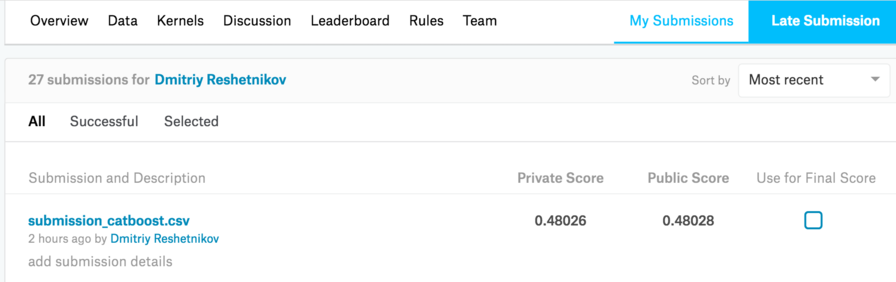

In [3]:
from IPython.display import Image
Image(filename='result.png')

# 7. What was done?

### Data prepartion:
- text may contain misspellings
- extract brand and material attributes that were mantioned as a very important
- prepare text features
    - remove stop words
    - stem words in text
- count amount of similar words in search_term and all other text columns

### Machine learning:
- figure out that we are going to solve regression task
- list all available regression algorithms available in the sklearn lib (LinearRegressor, RandomForestRegressor and so on)
- use GridSearchCV to find the best combination of parameters for each regressor to archive the best result
- compare regressors result
- submit best result to kaggle

### Best model description
Best model is based on __CatBoost__. Result on public leaderboard  is __0.48026__. More information about that regression algorithm may be found here https://tech.yandex.ru/catboost/

### Ways to improve

- Try to use Tf-Idf to vectorize text features
- Replace similarity features with similarity/(length of text)
- Try to use neutral networks
- Try to add several additional features to the model